# Computing reflectance as least squares fit

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

We will use the dark corrected (dark reference subtracted) DN values as the base data:

In [2]:
dn_ds = xr.open_dataset('C:/Temp/data/dark_corrected_dn.nc', chunks={'filename': 1})
dn_ds

<xarray.Dataset>
Dimensions:            (band: 128, filename: 23, x: 520, y: 696)
Coordinates:
  * filename           (filename) object '_I50_L0-511_3-10-2018_10.59.48_White' ... '_I50_L0-511_3-10-2018_14.0.19_Dark'
  * band               (band) int32 1 2 3 4 5 6 7 ... 123 124 125 126 127 128
  * y                  (y) float64 0.5 1.5 2.5 3.5 ... 692.5 693.5 694.5 695.5
  * x                  (x) float64 0.5 1.5 2.5 3.5 ... 516.5 517.5 518.5 519.5
Data variables:
    wavelength         (band) float64 dask.array<shape=(128,), chunksize=(128,)>
    distance           (filename) object dask.array<shape=(23,), chunksize=(1,)>
    tile               (filename) object dask.array<shape=(23,), chunksize=(1,)>
    dark_corrected_dn  (filename, band, y, x) uint16 dask.array<shape=(23, 128, 696, 520), chunksize=(1, 128, 696, 520)>

The white reference is the data from PTFE plaque level with the other tiles:

In [3]:
ref_file = '_I50_L0-511_3-10-2018_13.50.8_PTFE_'
dn_ds['reference_dn'] = dn_ds.sel(filename=ref_file)['dark_corrected_dn']

In [4]:
def color_pts(len_x, len_y):
    cr, cg = np.meshgrid(np.linspace(0, 1, len_x), np.linspace(0, 1, len_y))
    return np.stack([np.zeros(len_x*len_y), cr.ravel(), cg.ravel()], axis=1)


We select a set of pixels and plot the values of the sample against the reference at a given wavelength. The yellow dot is the center of mass of the points (mean of the sample points / mean of the reference points), and the line is the least squares fit of a line through the origin. Plots with "None" as their label are PTFE references at different heights and the dark reference.

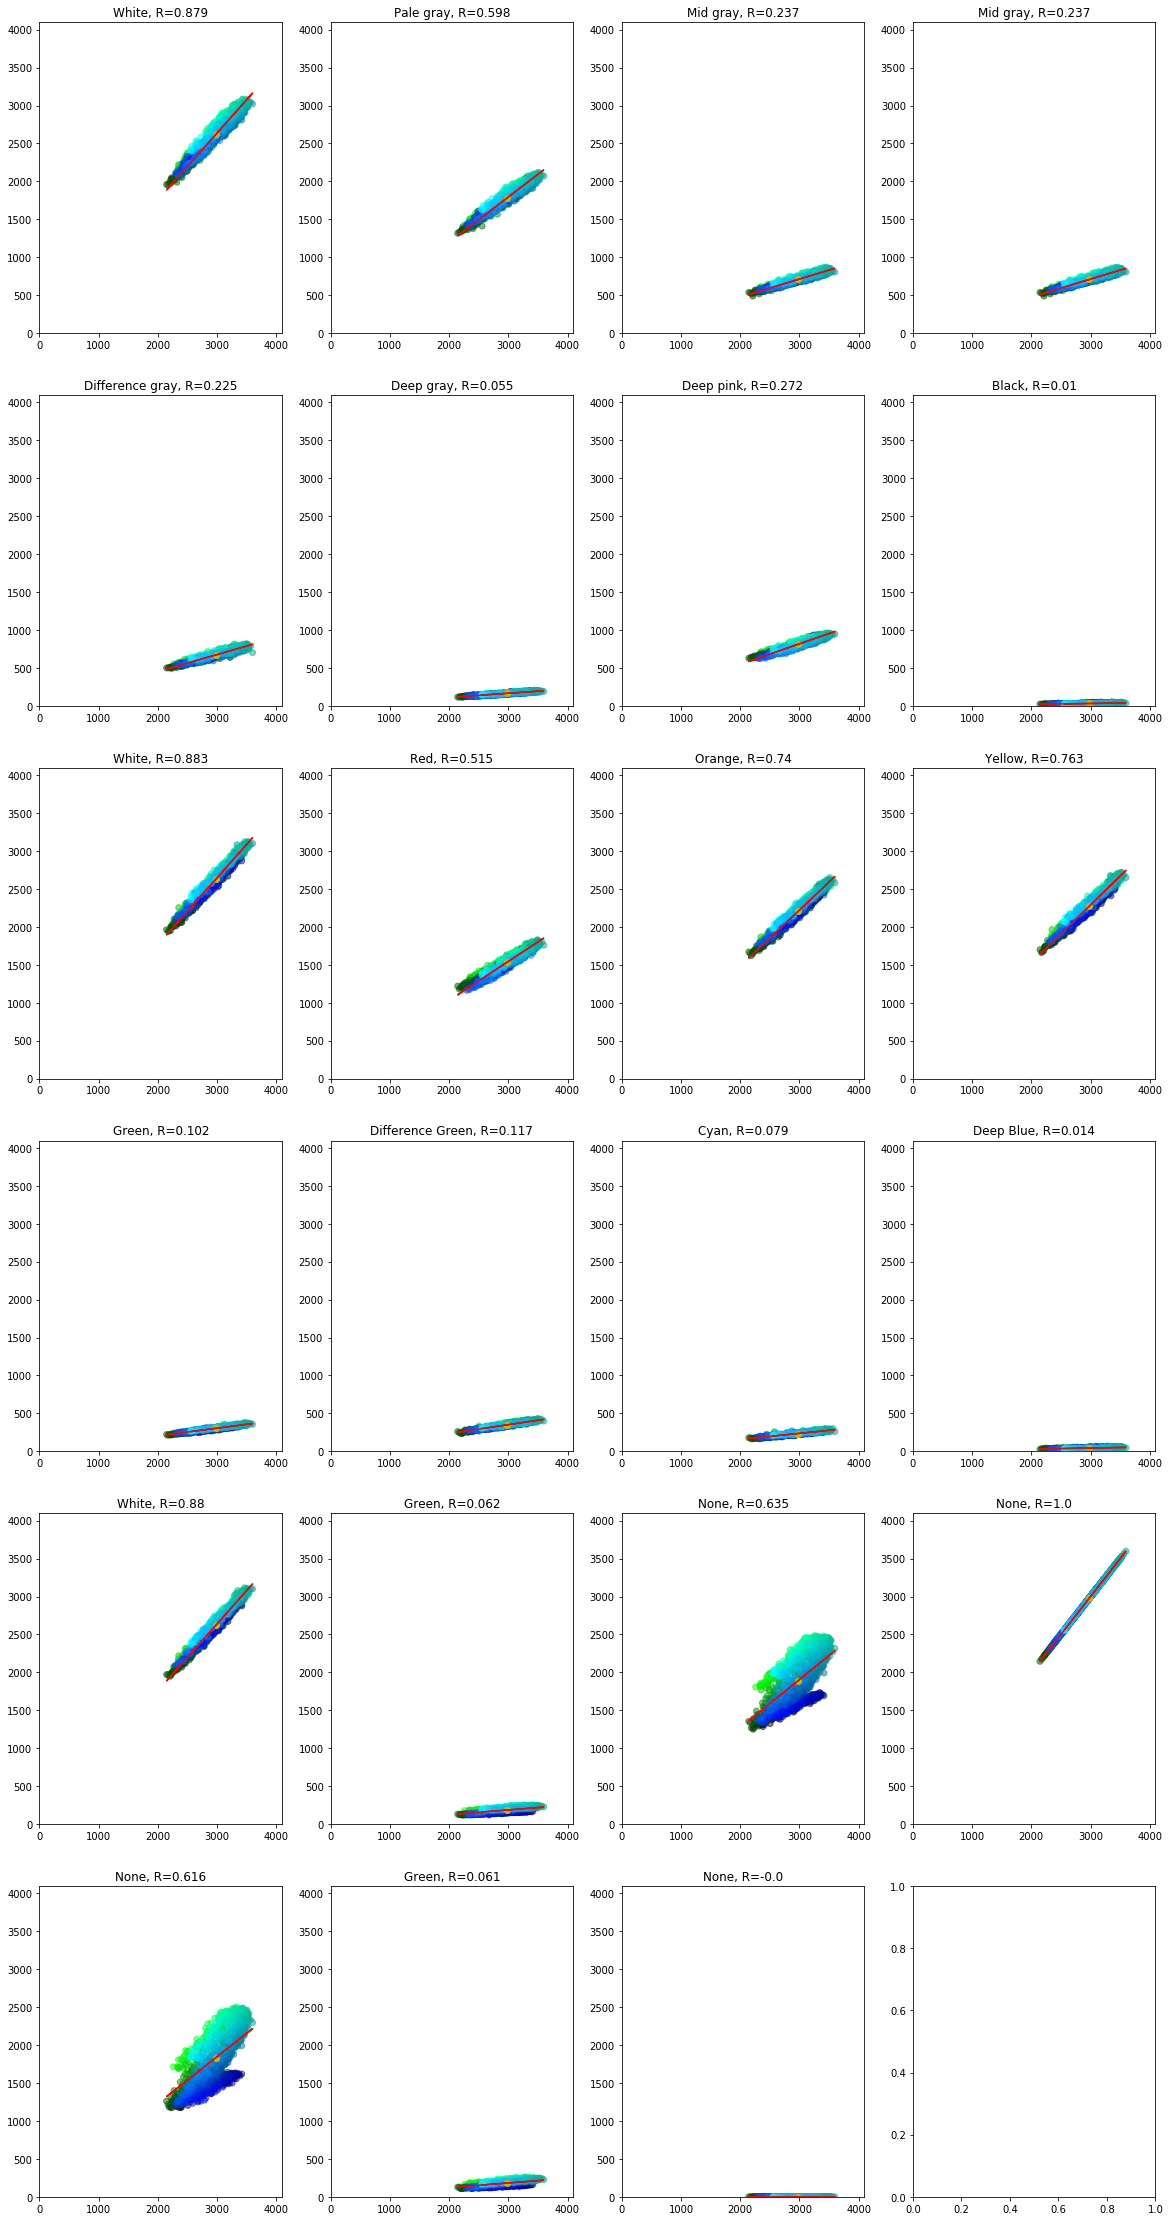

In [27]:
roi = {
    'x': slice(0, -1, 20),
    'y': slice(0, -1, 20),
}
boi = {'band': 50}

fig, axs = plt.subplots(ncols=4, nrows=6, figsize=(20,40))
axs = axs.ravel()
x = dn_ds.isel(**roi, **boi)['reference_dn'].data.ravel()
c = color_pts(dn_ds.isel(**roi).x.size, dn_ds.isel(**roi).y.size)
for k in range(dn_ds.filename.size):
    y = dn_ds.isel(filename=k, **roi, **boi)['dark_corrected_dn'].data.ravel()
    R = np.float64(np.linalg.lstsq(x.reshape(x.size, 1), y.reshape(y.size, 1), rcond=None)[0])
    axs[k].scatter(x, y, c=c, alpha=0.5)
    axs[k].scatter(np.mean(x), np.mean(y), color='y')
    axs[k].plot(x, R * x, color='r')
    axs[k].set_title(f"{dn_ds.isel(filename=k)['tile'].values}, R={np.round(R, decimals=3)}")
    axs[k].set_xlim((0, 4096))
    axs[k].set_ylim((0, 4096))

# Allowing an intercept
Next we compute a line fit of the same data, now allowing an intercept.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
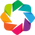

In [6]:
import holoviews as hv
hv.extension('bokeh', 'matplotlib')

In [7]:
from scipy.stats import linregress

In [16]:
def R_plot(filename, wavelength):
    ds = dn_ds.isel(**roi).swap_dims({'band': 'wavelength'})
    x = ds.sel(wavelength=wavelength)['reference_dn'].data.ravel()
    y = ds.sel(filename=filename, wavelength=wavelength)['dark_corrected_dn'].data.ravel()
    R, resid, _, _ = np.linalg.lstsq(x.reshape(x.size, 1), y.reshape(y.size, 1), rcond=None)
    fit = linregress(x, y)
    scatter = hv.Scatter(np.stack([x,y], axis=-1))
    line = hv.Curve([[0, 0],[4096, R * 4096]],  label=f'R={np.round(float(R), decimals=2)}, res/N_px={int(resid)/len(x)}').options({'Curve':{'color':'black'}})
    fit_line = hv.Curve([[0, fit[1]],[4096, fit[0] * 4096 + fit[1]]],  label=f'slope={np.round(fit[0], decimals=2)}, intercept/max(DN)={np.round(fit[1]/y.max(), decimals=2)}').options({'Curve':{'color':'red'}})
    return scatter * line * fit_line

In [17]:
%%output size=150
dmap = hv.DynamicMap(
    R_plot, kdims=['filename', 'wavelength'],
).redim.values(
    filename=dn_ds.filename.data,
    wavelength=dn_ds.wavelength.data
).redim(
    x=hv.Dimension('ref', label='Reference DN', range=(0, 4096)),
    y=hv.Dimension('dn', label='Sample DN', range=(0, 4096))
)
dmap

:DynamicMap   [filename,wavelength]
   :Overlay
      .Scatter.I                                                                                                              :Scatter   [ref]   (dn)
      .Curve.R_equals_0_full_stop_89_comma_res_over_N_px_equals_13_full_stop_098901098901099                                  :Curve   [ref]   (dn)
      .Curve.Slope_equals_0_full_stop_58_comma_intercept_over_max_left_parenthesis_DN_right_parenthesis_equals_0_full_stop_21 :Curve   [ref]   (dn)

In [18]:
def fit_R(ds):
    
    def fit(ds):
        x = ds['reference_dn'].data.ravel()
        y = ds['dark_corrected_dn'].data.ravel()
        res = linregress(x, y)
        ds['slope'], ds['intercept'], ds['rvalue'], ds['pvalue'], ds['stderr'] = res[0], res[1], res[2], res[3], res[4]
        return ds
    
    ds = ds.groupby('band').apply(fit)

    return ds


In [22]:
roi_fits_ds = dn_ds.isel(**roi).groupby('filename').apply(fit_R)

In [19]:
roi_fits_ds

<xarray.Dataset>
Dimensions:            (band: 128, filename: 23, x: 26, y: 35)
Coordinates:
  * y                  (y) float64 0.5 20.5 40.5 60.5 ... 640.5 660.5 680.5
  * x                  (x) float64 0.5 20.5 40.5 60.5 ... 460.5 480.5 500.5
  * band               (band) int32 1 2 3 4 5 6 7 ... 123 124 125 126 127 128
  * filename           (filename) object '_I50_L0-511_3-10-2018_10.59.48_White' ... '_I50_L0-511_3-10-2018_14.0.19_Dark'
Data variables:
    wavelength         (filename, band) float64 dask.array<shape=(23, 128), chunksize=(1, 1)>
    distance           (filename, band) object dask.array<shape=(23, 128), chunksize=(1, 1)>
    tile               (filename, band) object dask.array<shape=(23, 128), chunksize=(1, 1)>
    dark_corrected_dn  (filename, band, y, x) uint16 dask.array<shape=(23, 128, 35, 26), chunksize=(1, 1, 35, 26)>
    reference_dn       (filename, band, y, x) uint16 dask.array<shape=(23, 128, 35, 26), chunksize=(1, 1, 35, 26)>
    slope              (filena

In [23]:
refls = xr.open_dataset('C:/Temp/data/reflectances_from_means.nc')
refls.reference

<xarray.DataArray 'reference' (reference: 6)>
array(['_I50_L0-511_3-10-2018_10.59.48_White',
       '_I50_L0-511_3-10-2018_13.17.29_White',
       '_I50_L0-511_3-10-2018_13.33.40_White',
       '_I50_L0-511_3-10-2018_13.47.54_PTFE_bottom',
       '_I50_L0-511_3-10-2018_13.50.8_PTFE_',
       '_I50_L0-511_3-10-2018_13.52.45_PTFE_top'], dtype=object)
Coordinates:
  * reference  (reference) object '_I50_L0-511_3-10-2018_10.59.48_White' ... '_I50_L0-511_3-10-2018_13.52.45_PTFE_top'

In [25]:
def fit_plot(filename):
    ds = roi_fits_ds.sel(filename=filename).set_coords('wavelength').swap_dims({'band':'wavelength'})
    slope = hv.Curve(ds, kdims=['wavelength'], vdims='slope')
    intercept = hv.Curve(ds, kdims=['wavelength'], vdims='intercept')
    refl_ds = refls.sel(filename=filename, reference=ref_file).set_coords('wavelength').swap_dims({'band':'wavelength'})
    #R = hv.Curve(refl_ds, kdims=['wavelength'], vdims='reflectance', label='Reflectance of mean point')
    return slope + intercept

In [26]:
hv.DynamicMap(
    fit_plot, kdims=['filename']
).redim.values(
    filename=dn_ds.filename.data,
).redim.range(
    slope=(0,1),
    intercept=(-100, 1500),
)

:DynamicMap   [filename]
   :Layout
      .Curve.I  :Curve   [wavelength]   (slope)
      .Curve.II :Curve   [wavelength]   (intercept)